In [175]:
import xarray as xr
import numpy as np
import iris
import matplotlib.pyplot as plt
from xvortices.xvortices import load_cylind, project_to_cylind
import warnings; warnings.filterwarnings("ignore")
import cartopy.crs as ccrs

### Explore the dataset

In [143]:
# Load the data
df_plev = iris.load("D:/LEEDS/veronica/umnsaa_pb018.nc") ## .nc and .pp files work exactly the same

# Let's see what's in the dataset
print(df_plev)

zeta = df_plev.extract("atmosphere_relative_vorticity")[0]

0: atmosphere_relative_vorticity / (s-1) (time: 3; pressure: 17; latitude: 651; longitude: 600)
1: divergence_of_wind / (s-1)          (time: 3; pressure: 17; latitude: 651; longitude: 600)
2: geopotential_height / (m)           (time: 3; pressure: 17; latitude: 650; longitude: 600)
3: upward_air_velocity / (m s-1)       (time: 3; pressure: 17; latitude: 650; longitude: 600)
4: x_wind / (m s-1)                    (time: 3; pressure: 17; latitude: 651; longitude: 600)
5: y_wind / (m s-1)                    (time: 3; pressure: 17; latitude: 651; longitude: 600)


### Interrogate the data

In [23]:
# Let's take a look at the wind field
u,v = df_plev.extract(["x_wind","y_wind"])

for x in ['time','pressure','latitude','longitude']:
    print("{0} min: {1}, {0} max: {2}".format(x,u.coord(x).cell(0),u.coord(x).cell(-1)))

time min: 2019-03-23 19:00:00, time max: 2019-03-23 21:00:00
pressure min: 100.0, pressure max: 1000.0
latitude min: -26.0, latitude max: -13.0
longitude min: 110.0, longitude max: 121.979996


### Simple plan view plot

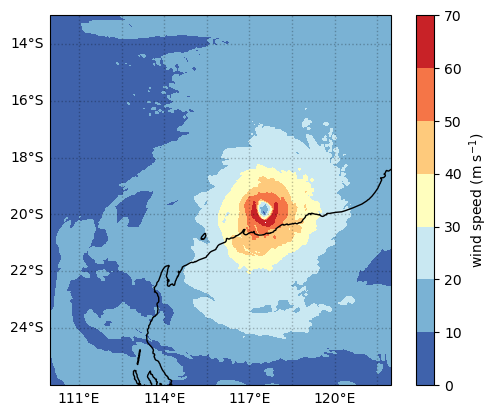

In [64]:
## Let's extract the data at 850 hPa and the first timestep 
u850 = u.extract(iris.Constraint(pressure=850))[0]
v850 = v.extract(iris.Constraint(pressure=850))[0]

## Calculate wind speed
wind_850 = np.sqrt(u850.data**2+v850.data**2)

## Plot the wind speed
fig = plt.figure()

ax = plt.axes(projection=ccrs.PlateCarree()) # This is a map projection
ax.coastlines() # Adds coastlines

X,Y = np.meshgrid(u850.coord('longitude').points,u850.coord('latitude').points) # Sets the grid for your plotting
shad = ax.contourf(X,Y,wind_850,cmap="RdYlBu_r",levels=np.arange(0,80,10)) # Plot
plt.colorbar(shad,ax=ax,label="wind speed (m s$^{-1}$)") # Add colorbar

## Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.25, linestyle='dotted')

gl.xlabels_top = False; gl.ylabels_right = False

plt.show()

## Simple way to find the centre

The data supplied below is not an ideal case, so the wind speed minimum doesn't perfectly match up with the centre of the storm. There are other more accurate methods you can use to find the storm centre, but we will use this one now for demonstration purposes.

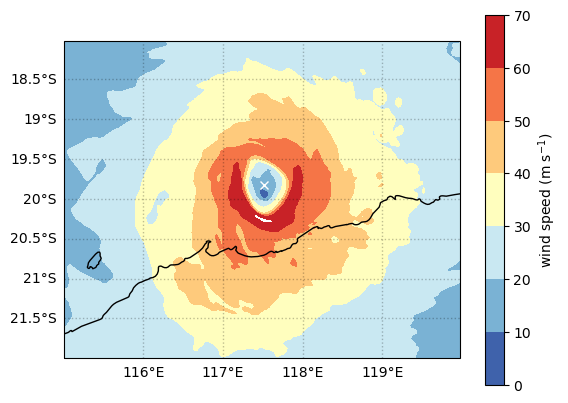

In [138]:
## First let's constrain the data to the storm region
u850_con = u850.extract(iris.Constraint(latitude=lambda x: -22 <= x < -18)&iris.Constraint(longitude=lambda x: 115 <= x < 120))
v850_con = v850.extract(iris.Constraint(latitude=lambda x: -22 <= x < -18)&iris.Constraint(longitude=lambda x: 115 <= x < 120))

## Calculate wind speed
ws_con = np.sqrt(u850_con.data**2+v850_con.data**2)

## Find minimum 
min_coords=np.where(ws_con==ws_con.min()) # finds coords where ws is at minimum
# Uses the coordinate arrays to match the minimum lat and lons to their index
min_lat = u850_con.coord('latitude').points[min_coords[0]]
min_lon = u850_con.coord('longitude').points[min_coords[1]]

## Let's re-plot 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree()) # This is a map projection
ax.coastlines() # Adds coastlines

X,Y = np.meshgrid(u850_con.coord('longitude').points,u850_con.coord('latitude').points) # Sets the grid for your plotting
shad = plt.contourf(X,Y,ws_con,cmap="RdYlBu_r",levels=np.arange(0,80,10)) # Plot
plt.colorbar(shad,ax=ax,label="wind speed (m s$^{-1}$)") # Add colorbar

## Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.25, linestyle='dotted')

gl.xlabels_top = False; gl.ylabels_right = False

## Add the min
plt.plot(min_lon,min_lat+0.12,color="white",marker="x")

plt.show()

## Cylindrical coordinates - tangential and radial wind

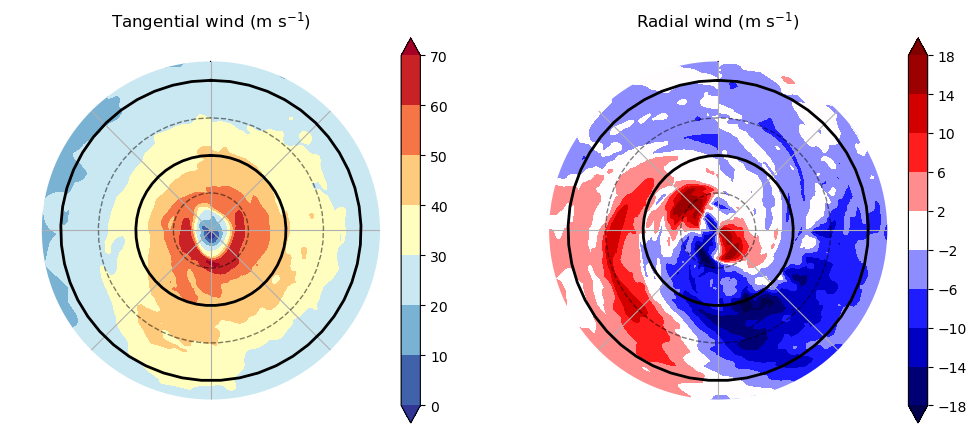

In [188]:
## Let's go back to the full data at a single timestep
## The xvortices package works with xarray instead of iris, but that's OK.
## The load_cylind function gives us radii and azimuth coordinates
[u_xr,v_xr], lons, lats, etas = load_cylind([xr.DataArray.from_iris(u[0]),xr.DataArray.from_iris(v[0])],
                                              min_lon, min_lat+0.12, azimNum=72, radiNum=250, radMax=250/111,
                lonname='longitude_0', latname='latitude_0')

## For the radial and tangential wind components, we need to convert u and v
## For this function you should really use the u and  v components with the storm motion removed
## In this case study, there was not much storm motion. For now, I will assume that it is 0.
tan, rad = project_to_cylind(u_xr, v_xr, etas)

## Now we can plot on a cylindrical coordinate system
fig, (ax1,ax2) = plt.subplots(1,2,subplot_kw=dict(projection='polar'),figsize=(12,5))
azis = np.radians(np.linspace(0,360,72)); radi = u_xr.radi
X,Y=np.meshgrid(azis,radi)

# Plot tangential - for tangential wind I multiply by -1 because this case is southern hemisphere
shad = ax1.contourf(X,Y,tan.values[-5,:,:]*-1,cmap="RdYlBu_r",levels=np.arange(0,80,10),extend="both")
plt.colorbar(shad,ax=ax1)
ax1.set_title("Tangential wind (m s$^{-1}$)")

# Plot radial
shad = ax2.contourf(X,Y,rad.values[-5,:,:],cmap="seismic",levels=np.arange(-18,22,4),extend="both")
plt.colorbar(shad,ax=ax2)
ax2.set_title("Radial wind (m s$^{-1}$)")

for ax in [ax1,ax2]:
    ax.set_theta_offset(1.570796327) # needs to be rotated to start from north
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    for radius in [0.5,1.5,2]:
        ax.plot(np.linspace(0, 2*np.pi, 50), np.ones(50)*radius, color='black', linestyle='dashed',linewidth=1,zorder=12,alpha=0.5)
    for radius in [1,2]:
        ax.plot(np.linspace(0, 2*np.pi, 50), np.ones(50)*radius, color='black', linestyle='solid',linewidth=2,zorder=12)

## Azimuthal mean

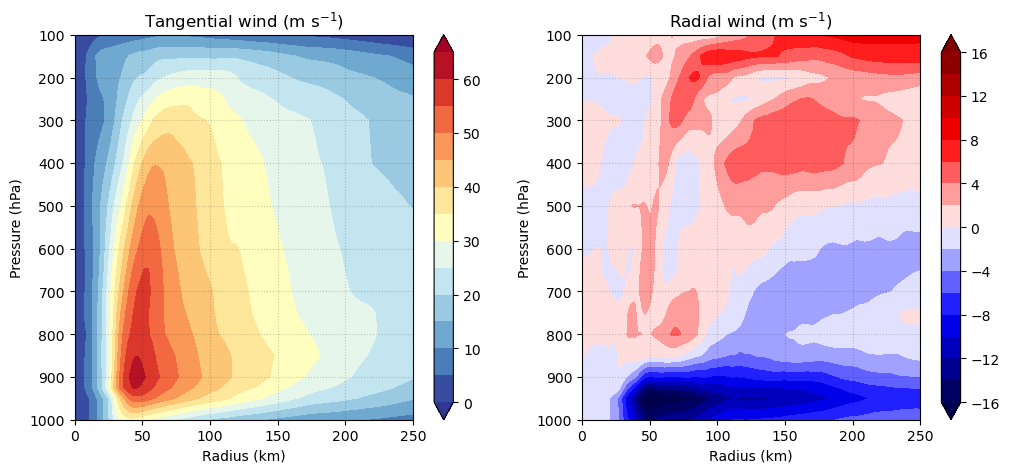

In [215]:
mean_tan = np.mean(tan.values,axis=2); mean_rad = np.mean(rad.values,axis=2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
X,Y = np.meshgrid(tan['radi']*111,tan['pressure'])
shad = ax1.contourf(X,Y,mean_tan*-1,cmap="RdYlBu_r",levels=np.arange(0,70,5),extend="both")
plt.colorbar(shad,ax=ax1); ax1.set_title("Tangential wind (m s$^{-1}$)")

shad = ax2.contourf(X,Y,mean_rad,cmap="seismic",levels=np.arange(-16,18,2),extend="both")
plt.colorbar(shad,ax=ax2); ax2.set_title("Radial wind (m s$^{-1}$)")

for ax in [ax1,ax2]:
    ax.invert_yaxis()
    ax.grid(color="black",linestyle="dotted",alpha=0.2)
    ax.set_xlabel("Radius (km)"); ax.set_ylabel("Pressure (hPa)")